# Test Vehicle Tracking


vehicles =  8792
image0 =  ../vehicles/GTI_Far/image0000.png
non_vehicles =  8968
image0 =  ../non-vehicles/Extras/extra1.png
Feature extracted :
scaled_X = 17760
y = 17760
feature length =  19272
Time 176.84 s
X_train = 17582
X_test = 178
y_train = 17582
y_test = 178
38.88 Seconds to train SVC...
Test Accuracy of SVC =  97.7528


'\n# Show Sample Images\nplt.subplot(1, 2, 1)\nvehicle_img = imread(vehicles[np.random.randint(0, len(vehicles))])\nplt.imshow(vehicle_img)\nplt.subplot(1, 2, 2)\nnon_vehicle_img = imread(non_vehicles[np.random.randint(0, len(non_vehicles))])\nplt.imshow(non_vehicle_img)\n'

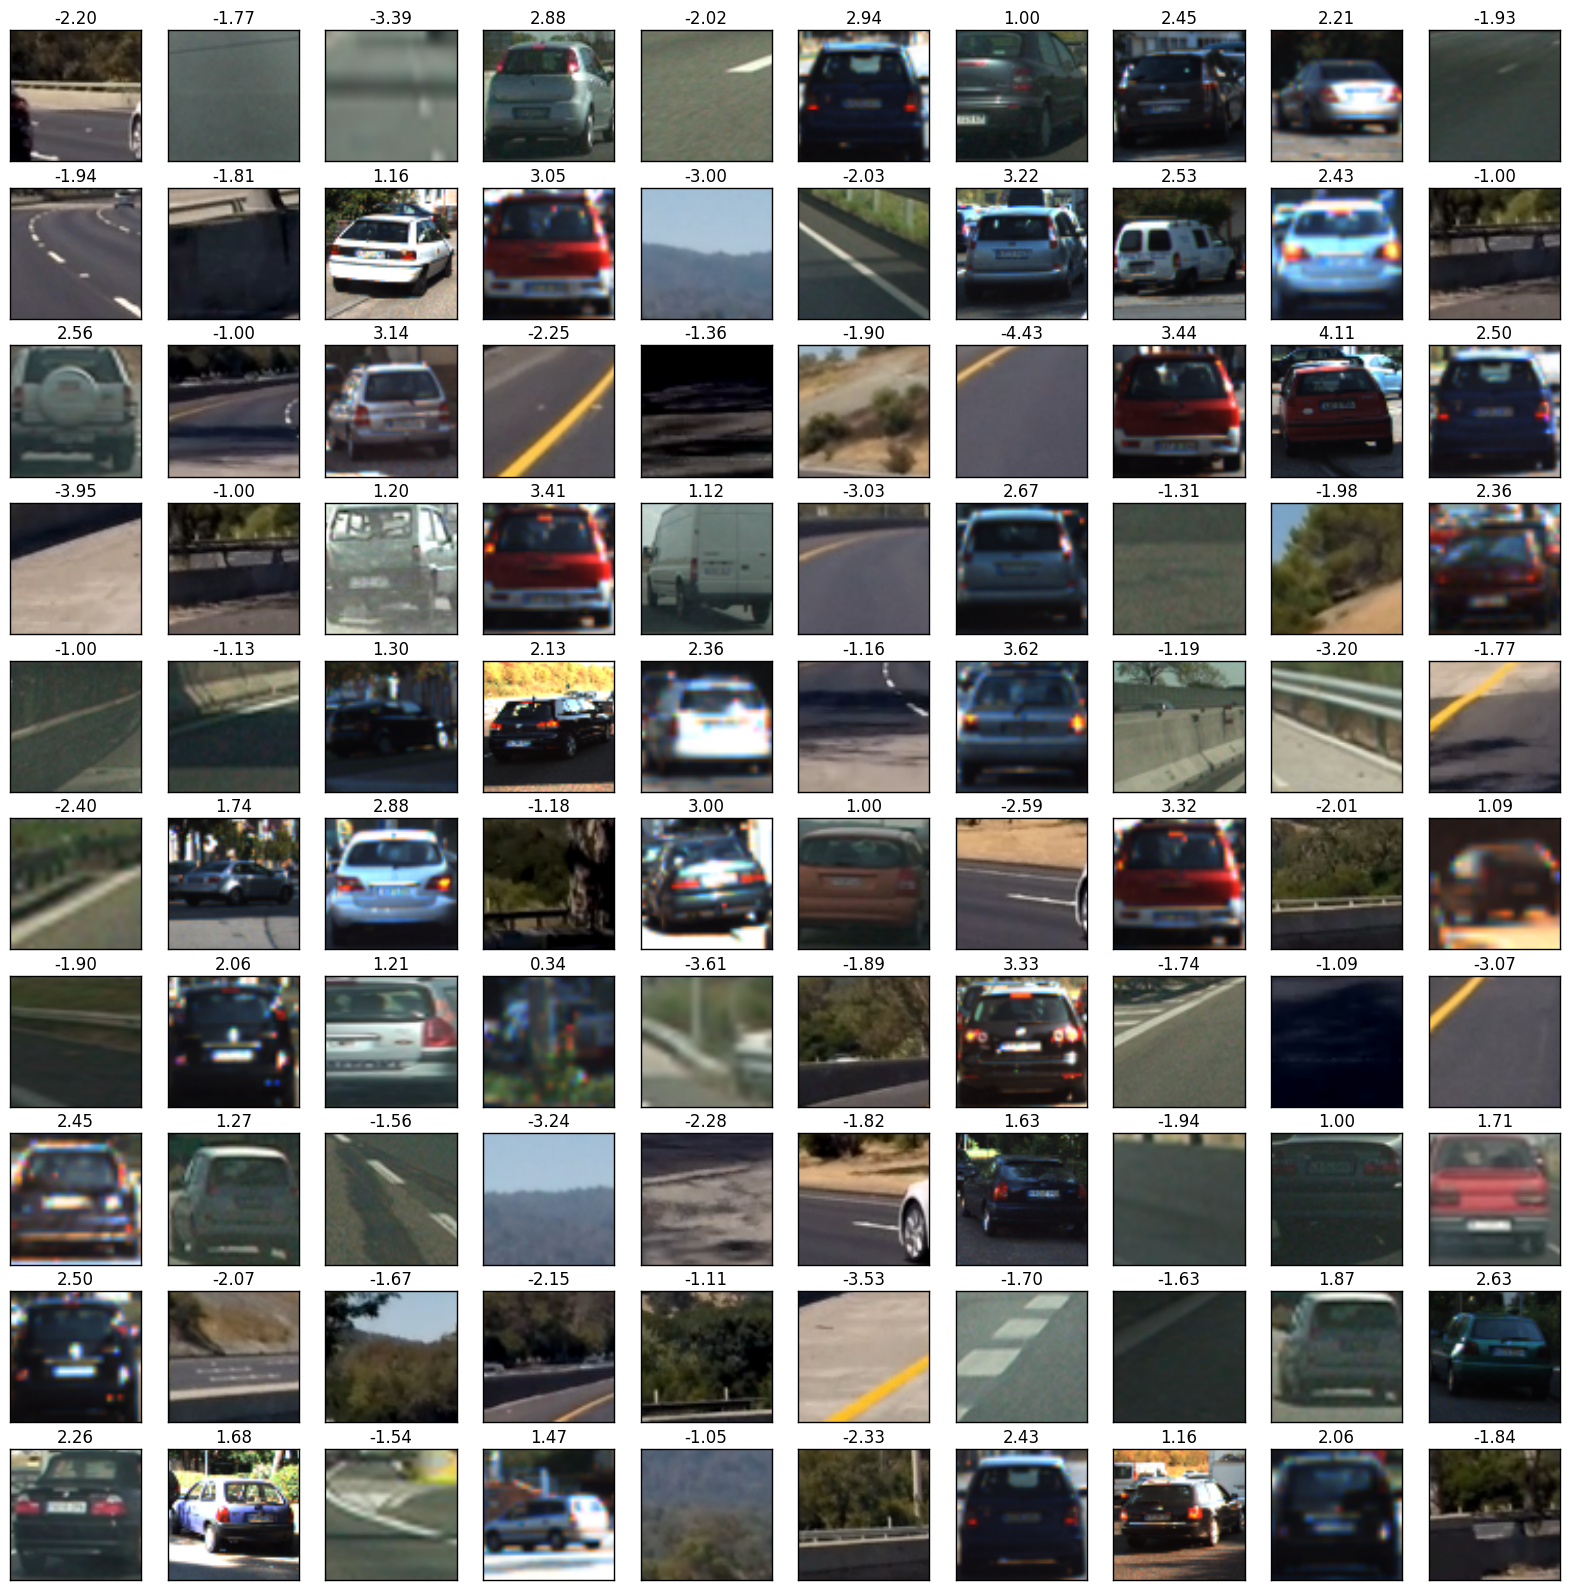

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sdc_functions import *
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline


vehicles_folder = '../vehicles'
non_vehicles_folder = '../non-vehicles'

vehicles = glob.glob(vehicles_folder + '/**/*.png', recursive=True)
print('vehicles = ', len(vehicles))
print('image0 = ', vehicles[0])

non_vehicles = glob.glob(non_vehicles_folder + '/**/*.png', recursive=True)
print('non_vehicles = ', len(non_vehicles))
print('image0 = ', non_vehicles[0])

### Subsample 
# sample_size = 500
# vehicles = np.random.choice(vehicles, sample_size)
# non_vehicles = np.random.choice(non_vehicles, sample_size)
# print('Sampled to %d images.' % sample_size)

### Parameters
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18  # HOG orientations
pix_per_cell = 6 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 720] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
t2=time.time()

print('Feature extracted :')
print('scaled_X =', len(scaled_X))
print('y =', len(y))
print('feature length = ', len(scaled_X[0]))
print('Time %.2f s' % (t2-t))



### Train SVC

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.01, random_state=rand_state)

print('X_train =', len(X_train));
print('X_test =', len(X_test));
print('y_train =', len(y_train));
print('y_test =', len(y_test));

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test)*100, 4))

## Store to file
with open('pickle_svc.p', 'wb') as f:
    pickle.dump(svc, f)
with open('pickle_scaler.p', 'wb') as f:
    pickle.dump(X_scaler, f)

## Restore
svc = pickle.load(open('pickle_svc.p', "rb" ))
X_scaler = pickle.load(open('pickle_scaler.p', "rb" ))

## Draw test prediction
# plt.figure(figsize=(20, 20))
f, axarr = plt.subplots(10, 10, figsize=(20, 20))
for r in range(len(axarr)):
    for c in range(len(axarr[0])):
        if np.random.uniform() < 0.5:
            im = imread(np.random.choice(vehicles))
        else:
            im = imread(np.random.choice(non_vehicles))
        im = cv2.resize(im, (64, 64))
        features = extract_features_img(im, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        decision = svc.decision_function(test_features)
        axarr[r, c].axes.get_xaxis().set_ticks([])
        axarr[r, c].axes.get_yaxis().set_ticks([])
        axarr[r, c].set_title("%.2f" % decision[0], fontsize=12)
        axarr[r, c].imshow(im)



'''
# Show Sample Images
plt.subplot(1, 2, 1)
vehicle_img = imread(vehicles[np.random.randint(0, len(vehicles))])
plt.imshow(vehicle_img)
plt.subplot(1, 2, 2)
non_vehicle_img = imread(non_vehicles[np.random.randint(0, len(non_vehicles))])
plt.imshow(non_vehicle_img)
'''


In [ ]:
# ### Train SVC

# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('X_train =', len(X_train));
# print('X_test =', len(X_test));
# print('y_train =', len(y_train));
# print('y_test =', len(y_test));

# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test)*100, 4))



  0%|          | 0/6 [00:00<?, ?it/s]

window_size= (160, 160) overlap= 0.7  num= 175 , 0.00 seconds
hog time 1.34 seconds
window_size= (128, 128) overlap= 0.7  num= 320 , 0.00 seconds
hog time 2.80 seconds
window_size= (96, 96) overlap= 0.6875  num= 533 , 0.00 seconds


 17%|█▋        | 1/6 [00:07<00:38,  7.76s/it]

hog time 3.41 seconds
windows_counts = [  5.   5.  12.]
window_size= (160, 160) overlap= 0.7  num= 175 , 0.00 seconds
hog time 1.19 seconds
window_size= (128, 128) overlap= 0.7  num= 320 , 0.00 seconds
hog time 2.31 seconds
window_size= (96, 96) overlap= 0.6875  num= 533 , 0.00 seconds


 33%|███▎      | 2/6 [00:14<00:30,  7.58s/it]

hog time 3.51 seconds
windows_counts = [ 0.  0.  0.]
window_size= (160, 160) overlap= 0.7  num= 175 , 0.00 seconds
hog time 1.15 seconds
window_size= (128, 128) overlap= 0.7  num= 320 , 0.00 seconds
hog time 2.00 seconds
window_size= (96, 96) overlap= 0.6875  num= 533 , 0.00 seconds


 50%|█████     | 3/6 [00:21<00:21,  7.29s/it]

hog time 3.34 seconds
windows_counts = [ 0.  0.  1.]
window_size= (160, 160) overlap= 0.7  num= 175 , 0.00 seconds
hog time 1.12 seconds
window_size= (128, 128) overlap= 0.7  num= 320 , 0.00 seconds
hog time 1.98 seconds
window_size= (96, 96) overlap= 0.6875  num= 533 , 0.00 seconds


 67%|██████▋   | 4/6 [00:28<00:14,  7.06s/it]

hog time 3.28 seconds
windows_counts = [ 4.  4.  8.]
window_size= (160, 160) overlap= 0.7  num= 175 , 0.00 seconds
hog time 1.10 seconds
window_size= (128, 128) overlap= 0.7  num= 320 , 0.00 seconds
hog time 1.96 seconds
window_size= (96, 96) overlap= 0.6875  num= 533 , 0.00 seconds


 83%|████████▎ | 5/6 [00:35<00:07,  7.08s/it]

hog time 3.91 seconds
windows_counts = [  4.   4.  11.]
window_size= (160, 160) overlap= 0.7  num= 175 , 0.00 seconds
hog time 1.22 seconds
window_size= (128, 128) overlap= 0.7  num= 320 , 0.00 seconds
hog time 2.08 seconds
window_size= (96, 96) overlap= 0.6875  num= 533 , 0.00 seconds


100%|██████████| 6/6 [00:42<00:00,  7.06s/it]

hog time 3.52 seconds
windows_counts = [ 3.  4.  5.]


'\n## Draw samples from all_hot_windows\n# plt.figure(figsize=(20, 20))\nf, axarr = plt.subplots(10, 10, figsize=(20, 20))\nfor r in range(len(axarr)):\n    for c in range(len(axarr[0])):\n        window = all_hot_windows[np.random.randint(0, len(all_hot_windows))]\n        im = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))\n        features = extract_features_img(im, color_space=color_space, \n                            spatial_size=spatial_size, hist_bins=hist_bins, \n                            orient=orient, pix_per_cell=pix_per_cell, \n                            cell_per_block=cell_per_block, \n                            hog_channel=hog_channel, spatial_feat=spatial_feat, \n                            hist_feat=hist_feat, hog_feat=hog_feat)\n        test_features = X_scaler.transform(np.array(features).reshape(1, -1))\n        decision = svc.decision_function(test_features)\n        axarr[r, c].axes.get_xaxis().set_ticks([])\n        axarr[r,

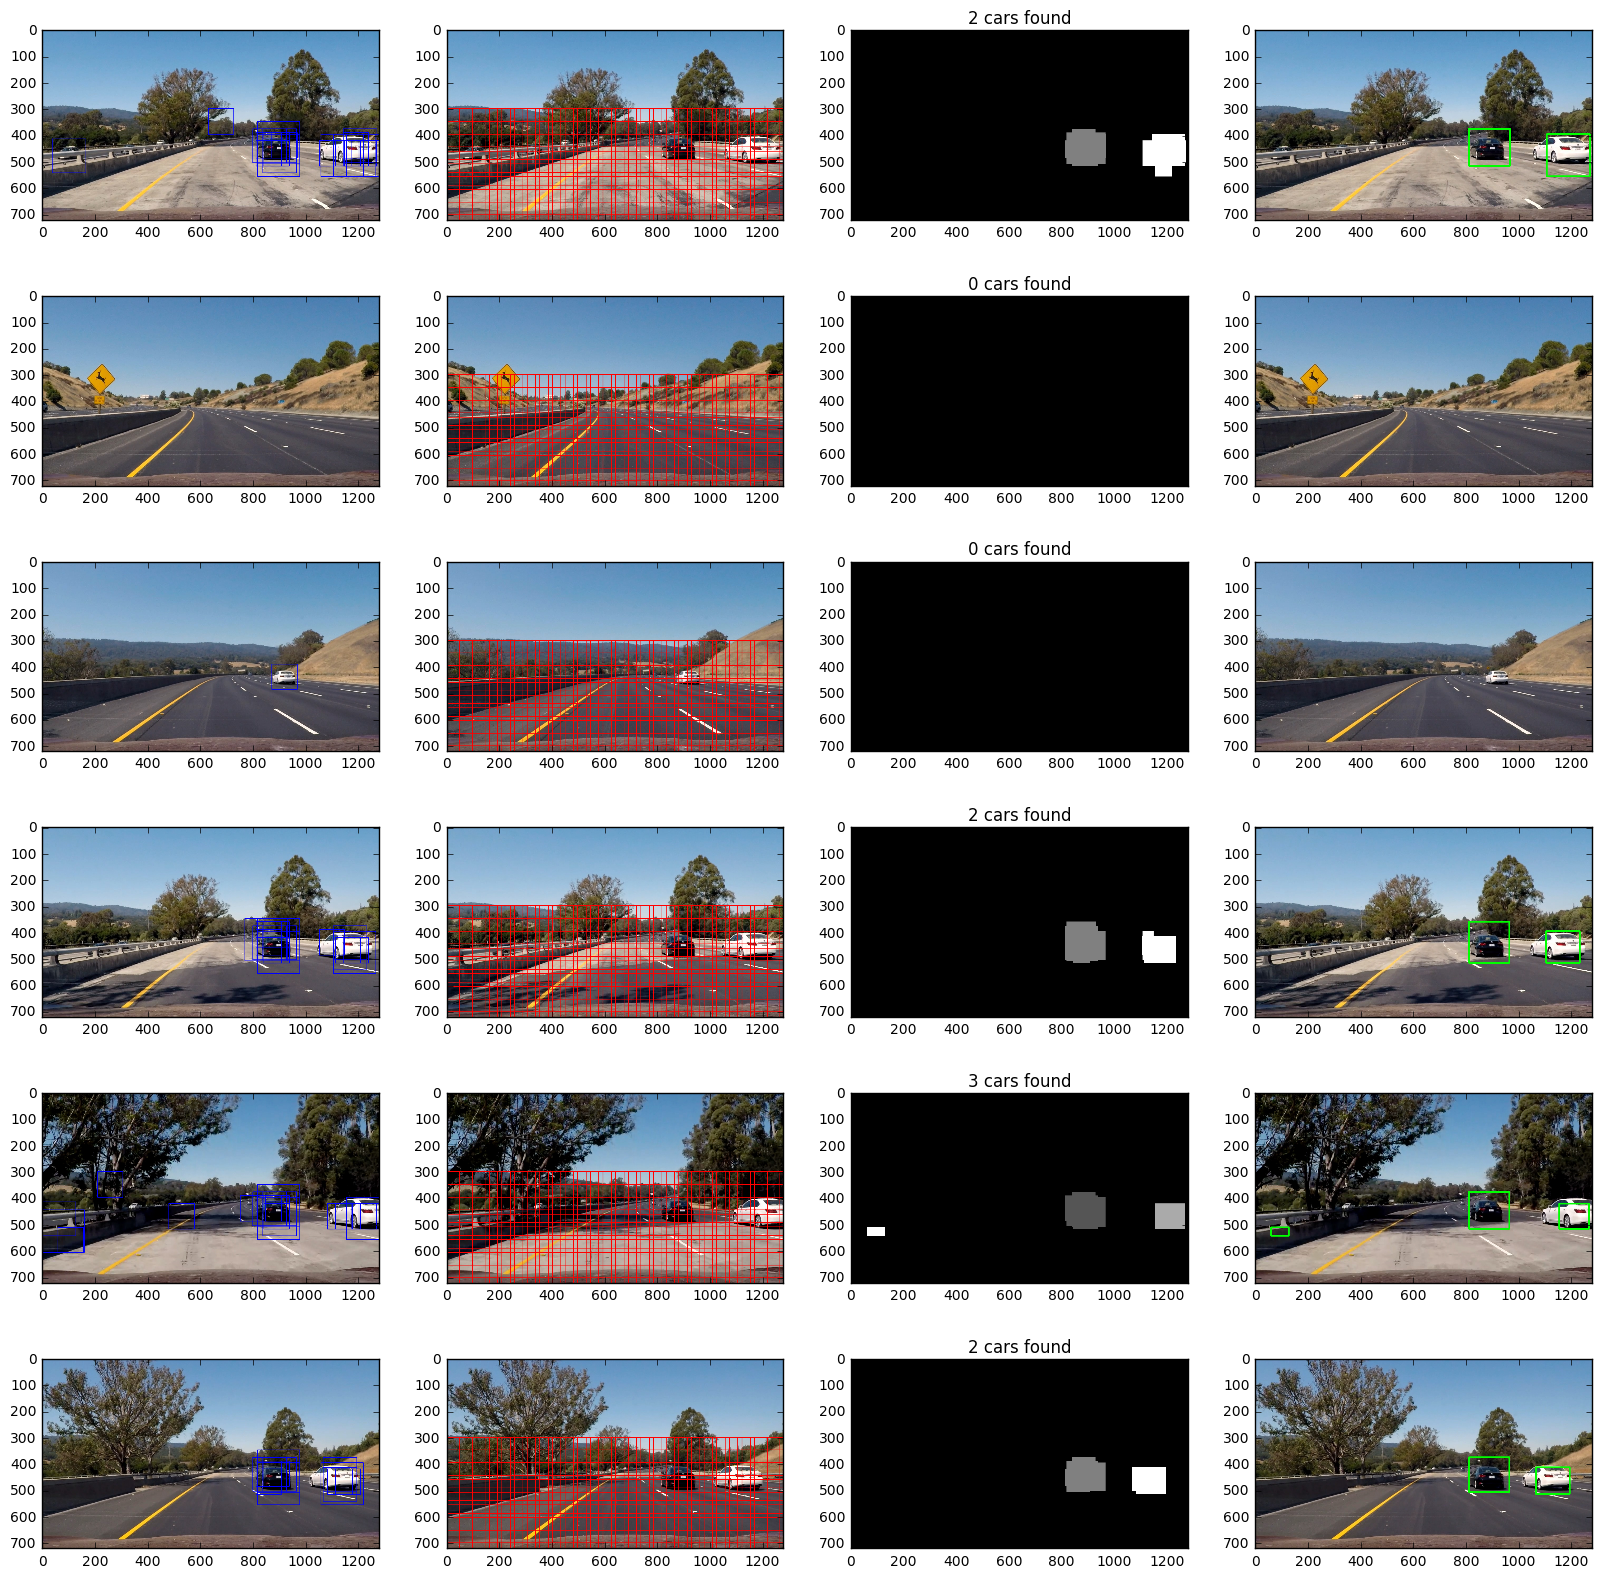

In [7]:
## Search in windows

# from sdc_functions import *

## Restore
svc = pickle.load(open('pickle_svc.p', "rb" ))
X_scaler = pickle.load(open('pickle_scaler.p', "rb" ))


test_images = ['test_images/test1.jpg',
              'test_images/test2.jpg',
              'test_images/test3.jpg',
              'test_images/test4.jpg',
              'test_images/test5.jpg',
              'test_images/test6.jpg']

# images = [imread(img) for img in test_images]

window_sizes = [160, 128, 96] # [256, 224, 192, 160, 128, 96, 64]
window_sizes_box = [(b, b) for b in window_sizes]
# print('window_sizes_box =', window_sizes_box)

f, axs = plt.subplots(6, 4, figsize=(20, 20))
for idx, timg in enumerate(tqdm(test_images)):
    image = imread(timg)
# image = imread('test_images/test5.jpg')
# image = imread('test_images/test2.jpg')
# image = imread('test_images/test3.jpg')
# image = imread('test_images/test4.jpg')
# image = imread('test_images/test5.jpg')
# image = imread('test_images/test6.jpg')
# print('image =', image)
# print('image2 =', imread(vehicles[0]))
# Normalize jpg to 0, 1
# image = image / 255

    draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255


    all_hot_windows = []
    all_windows = []
    windows_counts = np.zeros(len(window_sizes_box))
    for widx, window_size in enumerate(window_sizes_box):
        t = time.time()
        overlap_factor = 1. - max(0.3, 30.0/window_size[0])
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=window_size, xy_overlap=(overlap_factor, overlap_factor))
        all_windows.append(windows)
        t2 = time.time()
        
        print('window_size=',window_size,'overlap=',1-max(0.3, 30.0/window_size[0]),' num=', len(windows), ', %.2f seconds' % (t2-t) )

#     print('windows len =', len(windows))
#     print('windows[0] =', windows[0])

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        t3 = time.time()
        print('hog time %.2f seconds' % (t3-t2) )
    
        windows_counts[widx] += len(hot_windows)
        
    
        all_hot_windows.extend(hot_windows)
        
    print('windows_counts =', windows_counts)
    
    ## Draw All Boxes
    window_img = draw_boxes(draw_image, all_hot_windows, color=(0, 0, 255), thick=2)                    
    axs[idx, 0].imshow(window_img)
    
    ## Draw ALL ALL Boxes
    draw_image = np.copy(image)
    window_img = draw_boxes(draw_image, all_windows[0], color=(255, 0, 0), thick=2)                    
    axs[idx, 1].imshow(window_img)

    
    ## Heat Map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, all_hot_windows)

    heat = apply_threshold(heat, 2)
    labels = label(heat)
    
    ## Draw Heat Map
#     final_map = np.clip(heat, 0, 255)
#     axs[idx, 1].imshow(final_map, cmap='hot')
    
    


#     print(labels[1], 'cars found')
#     plt.subplot(1, 2, 2)

    ## Dtaw Labels Map
    axs[idx, 2].set_title('%d cars found' % labels[1])
    axs[idx, 2].imshow(labels[0], cmap='gray')
    
    ## Draw Outer Box
    draw_image = draw_labeled_bboxes(draw_image, labels)
    axs[idx, 3].imshow(draw_image)



'''
## Draw samples from all_hot_windows
# plt.figure(figsize=(20, 20))
f, axarr = plt.subplots(10, 10, figsize=(20, 20))
for r in range(len(axarr)):
    for c in range(len(axarr[0])):
        window = all_hot_windows[np.random.randint(0, len(all_hot_windows))]
        im = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features_img(im, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        decision = svc.decision_function(test_features)
        axarr[r, c].axes.get_xaxis().set_ticks([])
        axarr[r, c].axes.get_yaxis().set_ticks([])
        axarr[r, c].set_title("%.2f" % decision[0], fontsize=12)
        axarr[r, c].imshow(im)
        
        
## Draw test prediction
# plt.figure(figsize=(20, 20))
f, axarr = plt.subplots(5, 5, figsize=(20, 20))
for r in range(len(axarr)):
    for c in range(len(axarr[0])):
        if np.random.uniform() < 0.5:
            im = imread(np.random.choice(vehicles))
        else:
            im = imread(np.random.choice(non_vehicles))
        im = cv2.resize(im, (64, 64))
        features = extract_features_img(im, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        decision = svc.decision_function(test_features)
        axarr[r, c].axes.get_xaxis().set_ticks([])
        axarr[r, c].axes.get_yaxis().set_ticks([])
        axarr[r, c].set_title("%.2f" % decision[0], fontsize=12)
        axarr[r, c].imshow(im)

'''





In [ ]:
## Draw ALL ALL Boxes
# plt.figure(figsize=(20,10))
# draw_image = np.copy(image)
# window_img = draw_boxes(draw_image, all_windows[3], color=(255, 0, 0), thick=2)                    
# plt.imshow(window_img)


In [ ]:

# heat = np.zeros_like(image[:,:,0]).astype(np.float)
# heat = add_heat(heat, all_hot_windows)

# heat = apply_threshold(heat, 2)
# labels = label(heat)


# plt.figure(figsize=(20, 10))

# final_map = np.clip(heat - 2, 0, 255)
# plt.subplot(1, 2, 1)
# plt.imshow(final_map, cmap='hot')


# print(labels[1], 'cars found')
# plt.subplot(1, 2, 2)
# plt.imshow(labels[0], cmap='gray')


